# Fall Detection Inference using Smartphone Sensor Data

This notebook demonstrates how to use the trained right pocket CNN model to perform fall detection inference on a **single trial** recorded from a smartphone. Each CSV file represents one trial, and the model will classify whether it's a fall or non-fall activity.

## 1. Import Required Libraries

Import PyTorch, pandas, numpy, and other necessary libraries for model loading and data processing.

In [240]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

Libraries imported successfully!
PyTorch version: 2.9.1+cpu


## 2. Define Model Architecture

Define the ComplexCNN1D model class (same architecture as used in training).

In [241]:
# Define the ComplexCNN1D model class (same as in training)
class ComplexCNN1D(nn.Module):
    def __init__(self, input_shape):
        super(ComplexCNN1D, self).__init__()
        self.input_shape = input_shape

        # Initial Conv Layer
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=64, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)

        # First Residual Block
        self.conv2_shortcut = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1, padding='same')
        self.conv2_1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.bn2_1 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.conv2_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding='same')
        self.bn2_2 = nn.BatchNorm1d(128)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)

        # Second Residual Block
        self.conv3_shortcut = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1, padding='same')
        self.conv3_1 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.bn3_1 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.4)
        self.conv3_2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding='same')
        self.bn3_2 = nn.BatchNorm1d(256)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2)

        # Third Residual Block
        self.conv4_shortcut = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=1, padding='same')
        self.conv4_1 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn4_1 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.conv4_2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding='same')
        self.bn4_2 = nn.BatchNorm1d(512)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2)

        # Global Average Pooling and Fully Connected Layers
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, 1024)
        self.dropout5 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout6 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, x):
        # Initial Conv Layer
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        # First Residual Block
        shortcut = self.conv2_shortcut(x)
        x = F.relu(self.conv2_1(x))
        x = self.bn2_1(x)
        x = self.dropout2(x)
        x = F.relu(self.conv2_2(x))
        x = self.bn2_2(x)
        x = x + shortcut  # Residual connection
        x = self.maxpool2(x)

        # Second Residual Block
        shortcut = self.conv3_shortcut(x)
        x = F.relu(self.conv3_1(x))
        x = self.bn3_1(x)
        x = self.dropout3(x)
        x = F.relu(self.conv3_2(x))
        x = self.bn3_2(x)
        x = x + shortcut  # Residual connection
        x = self.maxpool3(x)

        # Third Residual Block
        shortcut = self.conv4_shortcut(x)
        x = F.relu(self.conv4_1(x))
        x = self.bn4_1(x)
        x = self.dropout4(x)
        x = F.relu(self.conv4_2(x))
        x = self.bn4_2(x)
        x = x + shortcut  # Residual connection
        x = self.maxpool4(x)

        # Global Average Pooling and Fully Connected Layers
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification

        return x

print("Model class defined successfully!")

Model class defined successfully!


## 3. Load the Trained Model

Load the right_pocket_model.pth file and set the model to evaluation mode.

In [242]:
# Load the trained model
try:
    # Initialize the model with the same architecture as training
    model = ComplexCNN1D(input_shape=(200, 6))  # 200 time steps, 6 sensor channels
    
    # Load the trained weights
    model.load_state_dict(torch.load('right_pocket_model.pth', map_location='cpu'))
    
    # Set to evaluation mode
    model.eval()
    
    print("✅ Model loaded successfully!")
    print(f"Model architecture: {model.__class__.__name__}")
    print(f"Input shape expected: (batch_size, 6, 200)")
    print(f"Output: Fall probability (0-1)")
    
except FileNotFoundError:
    print("❌ Error: right_pocket_model.pth not found!")
    print("Please ensure the model file is in the current directory.")
except Exception as e:
    print(f"❌ Error loading model: {e}")

✅ Model loaded successfully!
Model architecture: ComplexCNN1D
Input shape expected: (batch_size, 6, 200)
Output: Fall probability (0-1)


## 4. Load Smartphone Sensor Data (Single Trial)

Load the CSV file containing a single trial recorded from smartphone and extract the required sensor columns.

In [243]:
# PLACEHOLDER: Update this path with your actual smartphone data CSV file
# Each CSV file represents ONE trial (either a fall or non-fall activity)
SMARTPHONE_DATA_PATH = 'smartphone_sensor_data.csv'

# Load the smartphone sensor data
try:
    # Read the CSV file
    df_raw = pd.read_csv(SMARTPHONE_DATA_PATH)
    
    print("✅ Smartphone trial data loaded successfully!")
    print(f"Trial data shape: {df_raw.shape}")
    print(f"Total samples in this trial: {len(df_raw)}")
    print(f"\n📋 Available columns:")
    print(df_raw.columns.tolist())
    
    # Display first few rows
    print("\n🔍 First 5 rows of trial data:")
    display(df_raw.head())
    
except FileNotFoundError:
    print(f"❌ Error: {SMARTPHONE_DATA_PATH} not found!")
    print("\n📝 Please update SMARTPHONE_DATA_PATH with your actual CSV file path.")
    print("Expected columns: ax, ay, az, gx, gy, gz (accelerometer and gyroscope data)")
    print("Note: Each CSV should contain ONE trial (one complete activity)")
except Exception as e:
    print(f"❌ Error loading data: {e}")

✅ Smartphone trial data loaded successfully!
Trial data shape: (525, 7)
Total samples in this trial: 525

📋 Available columns:
['TimeMS', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']

🔍 First 5 rows of trial data:


,TimeMS,ax,ay,az,gx,gy,gz
0,49,-0.062134,1.001831,-0.023178,0.072774,-0.106374,-0.025794
1,106,-0.016541,0.988342,-0.006973,0.028570,0.052171,0.001990
2,163,-0.019577,0.948471,0.001678,-0.017986,0.129139,-0.016612
3,221,-0.020721,0.964584,-0.012772,0.055617,0.114465,-0.005907
4,278,-0.034698,1.037003,0.002289,0.055617,0.114465,-0.005907


## 5. Extract and Prepare Sensor Columns

Extract the required sensor columns (ax, ay, az, gx, gy, gz) and prepare them for model input.

In [244]:
# Extract the required sensor columns
try:
    # Define the expected column names
    REQUIRED_COLUMNS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    
    # Check if all required columns exist (case-insensitive)
    available_cols = df_raw.columns.str.lower().tolist()
    
    # Map to actual column names in the dataframe
    column_mapping = {}
    for req_col in REQUIRED_COLUMNS:
        found = False
        for actual_col in df_raw.columns:
            if actual_col.lower() == req_col:
                column_mapping[req_col] = actual_col
                found = True
                break
        if not found:
            print(f"Warning: Column '{req_col}' not found in data")
    
    if len(column_mapping) == 6:
        # Extract sensor data in the correct order
        sensor_data = df_raw[[column_mapping['ax'], column_mapping['ay'], column_mapping['az'],
                              column_mapping['gx'], column_mapping['gy'], column_mapping['gz']]].copy()
        
        # Rename columns to standard names
        sensor_data.columns = REQUIRED_COLUMNS
        
        print("Sensor columns extracted successfully!")
        print(f"Sensor data shape: {sensor_data.shape}")
        print(f"Columns: {sensor_data.columns.tolist()}")
        
        # IMPORTANT: Convert gyroscope from rad/s to deg/s
        # Model was trained on deg/s, smartphone data is in rad/s
        print("\nConverting gyroscope data from rad/s to deg/s...")
        sensor_data['gx'] = sensor_data['gx'] * 180.0 / np.pi
        sensor_data['gy'] = sensor_data['gy'] * 180.0 / np.pi
        sensor_data['gz'] = sensor_data['gz'] * 180.0 / np.pi
        print("Gyroscope conversion completed!")
        
        # Display statistics
        print("\nSensor Data Statistics (after conversion):")
        display(sensor_data.describe())
        
        # Check for missing values
        missing_values = sensor_data.isnull().sum()
        if missing_values.sum() > 0:
            print("\nMissing values detected:")
            print(missing_values[missing_values > 0])
            print("\nFilling missing values with forward fill...")
            sensor_data = sensor_data.ffill().bfill()
        else:
            print("\nNo missing values detected")
    else:
        print(f"\nERROR: Could not find all required columns")
        print(f"Found: {list(column_mapping.keys())}")
        print(f"Required: {REQUIRED_COLUMNS}")
        print(f"\nAvailable columns in your file: {df_raw.columns.tolist()}")
        
except Exception as e:
    print(f"ERROR extracting sensor columns: {e}")

Sensor columns extracted successfully!
Sensor data shape: (525, 6)
Columns: ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

Converting gyroscope data from rad/s to deg/s...
Gyroscope conversion completed!

Sensor Data Statistics (after conversion):


,ax,ay,az,gx,gy,gz
count,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
mean,0.581090,0.405216,-0.633660,1.814629,-0.803118,2.200245
std,0.289198,0.389004,0.206288,31.309359,44.679824,32.432492
min,-0.238419,-0.831192,-1.483002,-161.621264,-743.577013,-143.173428
25%,0.623520,0.337860,-0.697418,-0.161484,-0.905472,0.204285
50%,0.626816,0.341217,-0.693512,0.004501,-0.613297,0.325500
75%,0.628525,0.343582,-0.689728,0.154724,-0.389999,0.475693
max,4.984802,7.799271,0.362442,476.693765,352.599008,528.180222



No missing values detected


## 6. Visualize Sensor Data

Plot the accelerometer and gyroscope data to understand the signal patterns.

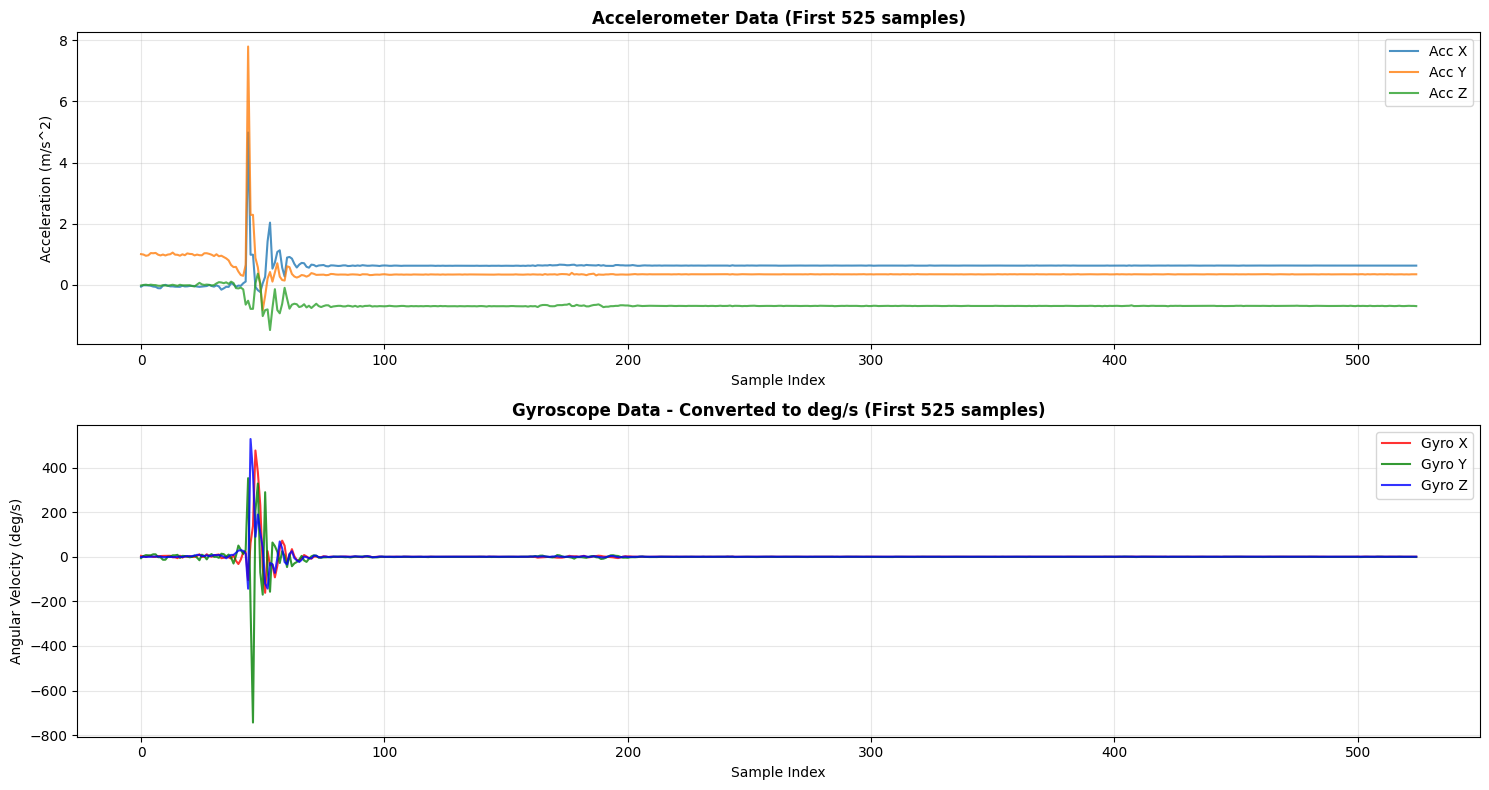

Sensor data visualized successfully!
Note: Gyroscope data has been converted from rad/s to deg/s for model compatibility


In [245]:
# Visualize the sensor data
try:
    plt.figure(figsize=(15, 8))
    
    # Plot first 1000 samples (or all if less than 1000)
    n_samples = min(1000, len(sensor_data))
    plot_data = sensor_data.head(n_samples)
    
    # Accelerometer data
    plt.subplot(2, 1, 1)
    plt.plot(plot_data['ax'], label='Acc X', alpha=0.8)
    plt.plot(plot_data['ay'], label='Acc Y', alpha=0.8)
    plt.plot(plot_data['az'], label='Acc Z', alpha=0.8)
    plt.title(f'Accelerometer Data (First {n_samples} samples)', fontsize=12, fontweight='bold')
    plt.xlabel('Sample Index')
    plt.ylabel('Acceleration (m/s^2)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Gyroscope data (converted to deg/s)
    plt.subplot(2, 1, 2)
    plt.plot(plot_data['gx'], label='Gyro X', alpha=0.8, color='red')
    plt.plot(plot_data['gy'], label='Gyro Y', alpha=0.8, color='green')
    plt.plot(plot_data['gz'], label='Gyro Z', alpha=0.8, color='blue')
    plt.title(f'Gyroscope Data - Converted to deg/s (First {n_samples} samples)', fontsize=12, fontweight='bold')
    plt.xlabel('Sample Index')
    plt.ylabel('Angular Velocity (deg/s)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Sensor data visualized successfully!")
    print("Note: Gyroscope data has been converted from rad/s to deg/s for model compatibility")
    
except Exception as e:
    print(f"ERROR visualizing data: {e}")

## 7. Create Windows for Trial Classification

Create sliding windows of 200 time steps from the trial data. Multiple windows will be analyzed, and the final classification will be based on aggregating predictions across all windows.

In [246]:
# Create sliding windows from the sensor data
def create_sliding_windows(data, window_length=200, step_size=50):
    """
    Create sliding windows from continuous sensor data
    
    Parameters:
    - data: DataFrame with sensor columns (ax, ay, az, gx, gy, gz)
    - window_length: Number of time steps per window (default: 200)
    - step_size: Step size for sliding window (default: 50, 75% overlap)
    
    Returns:
    - windows: numpy array of shape (n_windows, window_length, 6)
    - window_indices: list of (start_idx, end_idx) for each window
    """
    num_samples = len(data)
    
    if num_samples < window_length:
        print(f"⚠️ Warning: Data has only {num_samples} samples, need at least {window_length}")
        return None, None
    
    # Calculate number of windows
    num_windows = (num_samples - window_length) // step_size + 1
    
    # Initialize arrays
    windows = []
    window_indices = []
    
    # Create windows
    for i in range(num_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_length
        
        if end_idx <= num_samples:
            window = data.iloc[start_idx:end_idx].values
            windows.append(window)
            window_indices.append((start_idx, end_idx))
    
    return np.array(windows), window_indices

# Create windows from smartphone data
try:
    WINDOW_LENGTH = 200  # Time steps per window
    STEP_SIZE = 50       # Sliding step (75% overlap)
    
    windows, window_indices = create_sliding_windows(sensor_data, 
                                                      window_length=WINDOW_LENGTH,
                                                      step_size=STEP_SIZE)
    
    if windows is not None:
        print("✅ Sliding windows created successfully!")
        print(f"Window shape: {windows.shape}")
        print(f"Total windows: {len(windows)}")
        print(f"Window length: {WINDOW_LENGTH} time steps")
        print(f"Step size: {STEP_SIZE} (overlap: {(1 - STEP_SIZE/WINDOW_LENGTH)*100:.0f}%)")
        
        # Display sample window indices
        print(f"\n📊 Sample window indices:")
        for i in range(min(5, len(window_indices))):
            start, end = window_indices[i]
            print(f"  Window {i+1}: samples [{start}:{end}]")
    else:
        print("❌ Could not create windows - insufficient data")
        
except Exception as e:
    print(f"❌ Error creating windows: {e}")

✅ Sliding windows created successfully!
Window shape: (7, 200, 6)
Total windows: 7
Window length: 200 time steps
Step size: 50 (overlap: 75%)

📊 Sample window indices:
  Window 1: samples [0:200]
  Window 2: samples [50:250]
  Window 3: samples [100:300]
  Window 4: samples [150:350]
  Window 5: samples [200:400]


## 8. Preprocess Data for Model Input

Convert the windows to PyTorch tensors with the correct shape for the model.

In [247]:
# Prepare data for model input
def prepare_windows_for_model(windows):
    """
    Prepare windows for model input
    Input shape: (batch_size, time_steps, features) = (n, 200, 6)
    Output shape: (batch_size, features, time_steps) = (n, 6, 200) - for Conv1D
    """
    # Convert to tensor and permute dimensions for Conv1D
    tensor_data = torch.tensor(windows, dtype=torch.float32)
    tensor_data = tensor_data.permute(0, 2, 1)  # (batch_size, features, time_steps)
    
    return tensor_data

# Prepare windows for inference
try:
    if windows is not None:
        input_tensor = prepare_windows_for_model(windows)
        
        print("✅ Data preprocessed for model input")
        print(f"Input tensor shape: {input_tensor.shape}")
        print(f"Expected shape: (batch_size={len(windows)}, features=6, time_steps=200)")
        
        # Verify data ranges
        print(f"\n📊 Input Data Statistics:")
        print(f"Min value: {input_tensor.min().item():.3f}")
        print(f"Max value: {input_tensor.max().item():.3f}")
        print(f"Mean value: {input_tensor.mean().item():.3f}")
        print(f"Std value: {input_tensor.std().item():.3f}")
    else:
        print("❌ No windows to process")
        
except Exception as e:
    print(f"❌ Error preprocessing data: {e}")

✅ Data preprocessed for model input
Input tensor shape: torch.Size([7, 6, 200])
Expected shape: (batch_size=7, features=6, time_steps=200)

📊 Input Data Statistics:
Min value: -743.577
Max value: 528.180
Mean value: 0.128
Std value: 16.847


## 9. Perform Batch Inference on Trial

Run all windows through the model to get predictions. The final trial classification will be determined by aggregating window-level predictions.

In [248]:
# Perform batch inference on all windows
def batch_inference(model, data_tensor, batch_size=32):
    """
    Perform inference on batches of data
    """
    model.eval()
    all_probabilities = []
    
    with torch.no_grad():
        # Process in batches to avoid memory issues
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i:i+batch_size]
            probabilities = model(batch)
            all_probabilities.append(probabilities.squeeze())
    
    # Concatenate all results
    all_probabilities = torch.cat(all_probabilities).numpy()
    
    # Convert probabilities to binary predictions (threshold = 0.5)
    predictions = (all_probabilities >= 0.5).astype(int)
    
    return all_probabilities, predictions

# Run inference
try:
    if 'input_tensor' in locals() and input_tensor is not None:
        print("Running inference on all windows from this trial...")
        
        probabilities, predictions = batch_inference(model, input_tensor, batch_size=32)
        
        print("\nWindow-level inference completed!")
        print(f"Processed {len(probabilities)} windows from the trial")
        print(f"\nWindow-level Prediction Summary:")
        print(f"Windows predicting FALL: {np.sum(predictions)} ({np.sum(predictions)/len(predictions)*100:.1f}%)")
        print(f"Windows predicting NORMAL: {len(predictions) - np.sum(predictions)} ({(1-np.sum(predictions)/len(predictions))*100:.1f}%)")
        
        # ===== TRIAL-LEVEL CLASSIFICATION =====
        print("\n" + "="*80)
        print("TRIAL-LEVEL CLASSIFICATION")
        print("="*80)
        
        # Method 1: Majority voting
        majority_vote = 1 if np.sum(predictions) > len(predictions) / 2 else 0
        
        # Method 2: Maximum probability
        max_probability = np.max(probabilities)
        
        # Method 3: Average probability
        avg_probability = np.mean(probabilities)
        
        # Method 4: Any fall detection (if at least one window predicts fall)
        any_fall = 1 if np.sum(predictions) > 0 else 0
        
        # Method 5: Conservative (at least 30% of windows predict fall)
        conservative_threshold = 0.3
        conservative_pred = 1 if (np.sum(predictions) / len(predictions)) > conservative_threshold else 0
        
        print(f"\nClassification Methods:")
        print(f"\n1. Majority Vote (>50% windows predict fall):")
        if majority_vote == 1:
            print(f"   Classification: FALL DETECTED")
        else:
            print(f"   Classification: NORMAL ACTIVITY")
        print(f"   Fall windows: {np.sum(predictions)}/{len(predictions)} ({np.sum(predictions)/len(predictions)*100:.1f}%)")
        
        print(f"\n2. Maximum Probability Approach:")
        print(f"   Max probability: {max_probability:.4f} ({max_probability*100:.1f}%)")
        if max_probability >= 0.5:
            print(f"   Classification: FALL DETECTED")
        else:
            print(f"   Classification: NORMAL ACTIVITY")
        
        print(f"\n3. Average Probability Approach:")
        print(f"   Avg probability: {avg_probability:.4f} ({avg_probability*100:.1f}%)")
        if avg_probability >= 0.5:
            print(f"   Classification: FALL DETECTED")
        else:
            print(f"   Classification: NORMAL ACTIVITY")
        
        print(f"\n4. Any Fall Detection (>=1 window predicts fall):")
        if any_fall == 1:
            print(f"   Classification: FALL DETECTED")
        else:
            print(f"   Classification: NORMAL ACTIVITY")
        
        print(f"\n5. Conservative Approach (>=30% windows predict fall):")
        if conservative_pred == 1:
            print(f"   Classification: FALL DETECTED")
        else:
            print(f"   Classification: NORMAL ACTIVITY")
        
        # Recommended classification (using majority vote as default)
        print(f"\n" + "="*80)
        print(f"RECOMMENDED CLASSIFICATION (Majority Vote):")
        if majority_vote == 1:
            print(f">>> FALL DETECTED <<<")
        else:
            print(f">>> NORMAL ACTIVITY <<<")
        print(f"Confidence: {max(np.sum(predictions)/len(predictions), 1 - np.sum(predictions)/len(predictions))*100:.1f}%")
        print("="*80)
        
    else:
        print("ERROR: No input tensor available for inference")
        
except Exception as e:
    print(f"ERROR during inference: {e}")

Running inference on all windows from this trial...

Window-level inference completed!
Processed 7 windows from the trial

Window-level Prediction Summary:
Windows predicting FALL: 1 (14.3%)
Windows predicting NORMAL: 6 (85.7%)

TRIAL-LEVEL CLASSIFICATION

Classification Methods:

1. Majority Vote (>50% windows predict fall):
   Classification: NORMAL ACTIVITY
   Fall windows: 1/7 (14.3%)

2. Maximum Probability Approach:
   Max probability: 0.9998 (100.0%)
   Classification: FALL DETECTED

3. Average Probability Approach:
   Avg probability: 0.1438 (14.4%)
   Classification: NORMAL ACTIVITY

4. Any Fall Detection (>=1 window predicts fall):
   Classification: FALL DETECTED

5. Conservative Approach (>=30% windows predict fall):
   Classification: NORMAL ACTIVITY

RECOMMENDED CLASSIFICATION (Majority Vote):
>>> NORMAL ACTIVITY <<<
Confidence: 85.7%

Window-level inference completed!
Processed 7 windows from the trial

Window-level Prediction Summary:
Windows predicting FALL: 1 (14.3%)


## 10. Analyze and Visualize Results

Create visualizations and detailed analysis of the fall detection predictions.

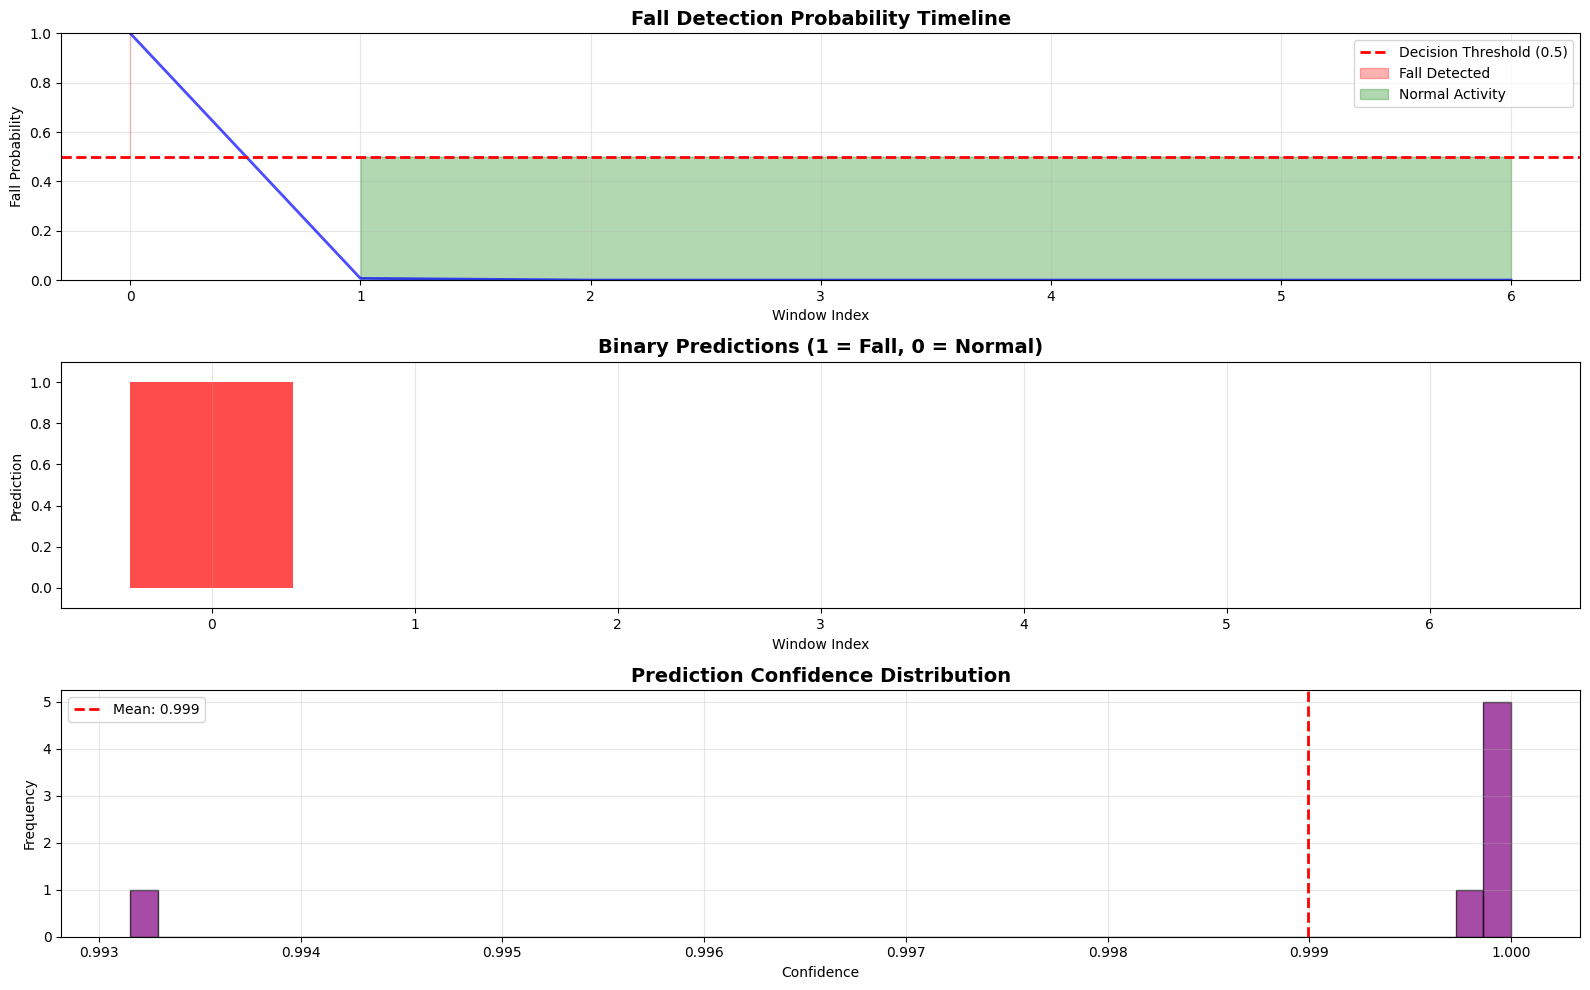

✅ Results visualized successfully!


In [249]:
# Visualize inference results
try:
    if 'probabilities' in locals() and probabilities is not None:
        plt.figure(figsize=(16, 10))
        
        # Plot 1: Probability timeline
        plt.subplot(3, 1, 1)
        plt.plot(probabilities, linewidth=2, color='blue', alpha=0.7)
        plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
        plt.fill_between(range(len(probabilities)), probabilities, 0.5, 
                        where=(probabilities >= 0.5), alpha=0.3, color='red', label='Fall Detected')
        plt.fill_between(range(len(probabilities)), probabilities, 0.5, 
                        where=(probabilities < 0.5), alpha=0.3, color='green', label='Normal Activity')
        plt.title('Fall Detection Probability Timeline', fontsize=14, fontweight='bold')
        plt.xlabel('Window Index')
        plt.ylabel('Fall Probability')
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Plot 2: Binary predictions
        plt.subplot(3, 1, 2)
        plt.bar(range(len(predictions)), predictions, color=['red' if p == 1 else 'green' for p in predictions], alpha=0.7)
        plt.title('Binary Predictions (1 = Fall, 0 = Normal)', fontsize=14, fontweight='bold')
        plt.xlabel('Window Index')
        plt.ylabel('Prediction')
        plt.ylim(-0.1, 1.1)
        plt.grid(True, alpha=0.3, axis='x')
        
        # Plot 3: Confidence distribution
        plt.subplot(3, 1, 3)
        confidence = np.maximum(probabilities, 1 - probabilities)
        plt.hist(confidence, bins=50, color='purple', alpha=0.7, edgecolor='black')
        plt.axvline(x=confidence.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {confidence.mean():.3f}')
        plt.title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Confidence')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Results visualized successfully!")
    else:
        print("❌ No predictions to visualize")
        
except Exception as e:
    print(f"❌ Error visualizing results: {e}")

## 11. Detailed Trial Analysis

Generate a detailed analysis of the trial including window-level predictions and the final trial classification.

In [250]:
# Create detailed trial analysis
try:
    if 'probabilities' in locals() and 'window_indices' in locals():
        # Create results dataframe
        results_df = pd.DataFrame({
            'window_id': range(len(probabilities)),
            'start_sample': [idx[0] for idx in window_indices],
            'end_sample': [idx[1] for idx in window_indices],
            'probability': probabilities,
            'prediction': predictions,
            'confidence': np.maximum(probabilities, 1 - probabilities)
        })
        
        # Add prediction label
        results_df['prediction_label'] = results_df['prediction'].map({0: 'Normal', 1: 'Fall'})
        
        print("=" * 80)
        print("DETAILED TRIAL ANALYSIS")
        print("=" * 80)
        
        # Trial-level classification
        majority_vote = 1 if np.sum(predictions) > len(predictions) / 2 else 0
        max_probability = np.max(probabilities)
        avg_probability = np.mean(probabilities)
        
        print(f"\nFINAL TRIAL CLASSIFICATION:")
        if majority_vote == 1:
            print(">>> FALL DETECTED <<<")
        else:
            print(">>> NORMAL ACTIVITY <<<")
        
        print(f"\nClassification confidence: {max(np.sum(predictions)/len(predictions), 1 - np.sum(predictions)/len(predictions))*100:.1f}%")
        print(f"Method used: Majority voting across {len(predictions)} windows")
        
        # Window-level statistics
        print(f"\nWindow-level Statistics:")
        print(f"Total trial samples: {sensor_data.shape[0]}")
        print(f"Total windows analyzed: {len(results_df)}")
        print(f"Fall windows: {results_df['prediction'].sum()} ({results_df['prediction'].sum()/len(results_df)*100:.1f}%)")
        print(f"Normal windows: {len(results_df) - results_df['prediction'].sum()} ({(1-results_df['prediction'].sum()/len(results_df))*100:.1f}%)")
        print(f"Average probability: {results_df['probability'].mean():.4f}")
        print(f"Maximum probability: {results_df['probability'].max():.4f}")
        print(f"Minimum probability: {results_df['probability'].min():.4f}")
        print(f"Average confidence: {results_df['confidence'].mean():.4f}")
        
        # High-confidence fall windows
        high_conf_falls = results_df[(results_df['prediction'] == 1) & (results_df['probability'] > 0.9)]
        if len(high_conf_falls) > 0:
            print(f"\nHigh-confidence fall windows detected: {len(high_conf_falls)}")
            print(f"Window IDs: {high_conf_falls['window_id'].tolist()}")
            print(f"Max probability: {high_conf_falls['probability'].max():.4f}")
        
        # Display ALL window results
        print(f"\nWindow-level Predictions (All {len(results_df)} windows):")
        display(results_df)
        
        # Save detailed results
        output_file = 'trial_inference_results.csv'
        results_df.to_csv(output_file, index=False)
        
        # Save trial summary
        summary_file = 'trial_summary.txt'
        with open(summary_file, 'w') as f:
            f.write("="*80 + "\n")
            f.write("TRIAL CLASSIFICATION SUMMARY\n")
            f.write("="*80 + "\n\n")
            f.write(f"Data file: {SMARTPHONE_DATA_PATH}\n")
            f.write(f"Total samples: {sensor_data.shape[0]}\n")
            f.write(f"Total windows: {len(results_df)}\n\n")
            f.write(f"FINAL CLASSIFICATION: {'FALL DETECTED' if majority_vote == 1 else 'NORMAL ACTIVITY'}\n")
            f.write(f"Confidence: {max(np.sum(predictions)/len(predictions), 1 - np.sum(predictions)/len(predictions))*100:.1f}%\n\n")
            f.write(f"Fall windows: {results_df['prediction'].sum()} ({results_df['prediction'].sum()/len(results_df)*100:.1f}%)\n")
            f.write(f"Average probability: {avg_probability:.4f}\n")
            f.write(f"Maximum probability: {max_probability:.4f}\n")
        
        print(f"\nDetailed results saved to: {output_file}")
        print(f"Trial summary saved to: {summary_file}")
        
    else:
        print("ERROR: No results to analyze")
        
except Exception as e:
    print(f"ERROR creating analysis: {e}")

DETAILED TRIAL ANALYSIS

FINAL TRIAL CLASSIFICATION:
>>> NORMAL ACTIVITY <<<

Classification confidence: 85.7%
Method used: Majority voting across 7 windows

Window-level Statistics:
Total trial samples: 525
Total windows analyzed: 7
Fall windows: 1 (14.3%)
Normal windows: 6 (85.7%)
Average probability: 0.1438
Maximum probability: 0.9998
Minimum probability: 0.0000
Average confidence: 0.9990

High-confidence fall windows detected: 1
Window IDs: [0]
Max probability: 0.9998

Window-level Predictions (All 7 windows):


,window_id,start_sample,end_sample,probability,prediction,confidence,prediction_label
0,0,0,200,9.998122e-01,1,0.999812,Fall
1,1,50,250,6.844248e-03,0,0.993156,Normal
2,2,100,300,5.713839e-07,0,0.999999,Normal
3,3,150,350,5.694760e-07,0,0.999999,Normal
4,4,200,400,4.392104e-08,0,1.000000,Normal
5,5,250,450,4.199113e-08,0,1.000000,Normal
6,6,300,500,4.195774e-08,0,1.000000,Normal



Detailed results saved to: trial_inference_results.csv
Trial summary saved to: trial_summary.txt


## 12. Real-time Prediction Function

Create a function for real-time fall detection on new sensor data streams.

In [251]:
# Real-time prediction function
def predict_single_window(model, sensor_window):
    """
    Predict fall detection on a single window of sensor data
    
    Parameters:
    - model: Trained PyTorch model
    - sensor_window: numpy array or DataFrame with shape (200, 6)
                     Columns: [ax, ay, az, gx, gy, gz]
    
    Returns:
    - probability: Fall probability (0-1)
    - prediction: Binary prediction (0=Normal, 1=Fall)
    - confidence: Prediction confidence (0-1)
    """
    if isinstance(sensor_window, pd.DataFrame):
        sensor_window = sensor_window.values
    
    if sensor_window.shape != (200, 6):
        raise ValueError(f"Expected shape (200, 6), got {sensor_window.shape}")
    
    # Convert to tensor and add batch dimension
    tensor_data = torch.tensor(sensor_window, dtype=torch.float32)
    tensor_data = tensor_data.unsqueeze(0).permute(0, 2, 1)  # (1, 6, 200)
    
    # Perform inference
    model.eval()
    with torch.no_grad():
        probability = model(tensor_data).item()
        prediction = 1 if probability >= 0.5 else 0
        confidence = max(probability, 1 - probability)
    
    return probability, prediction, confidence

# Test the function with a sample window
try:
    if 'windows' in locals() and windows is not None and len(windows) > 0:
        test_window = windows[0]
        prob, pred, conf = predict_single_window(model, test_window)
        
        print("✅ Real-time prediction function ready!")
        print(f"\n🧪 Test prediction on first window:")
        print(f"  Probability: {prob:.4f} ({prob*100:.1f}%)")
        print(f"  Prediction: {'Fall' if pred == 1 else 'Normal'}")
        print(f"  Confidence: {conf:.4f} ({conf*100:.1f}%)")
        
        print(f"\n📖 Usage:")
        print(f"  probability, prediction, confidence = predict_single_window(model, your_200x6_data)")
    else:
        print("✅ Real-time prediction function ready!")
        print(f"\n📖 Usage:")
        print(f"  probability, prediction, confidence = predict_single_window(model, your_200x6_data)")
        
except Exception as e:
    print(f"❌ Error testing prediction function: {e}")

✅ Real-time prediction function ready!

🧪 Test prediction on first window:
  Probability: 0.9998 (100.0%)
  Prediction: Fall
  Confidence: 0.9998 (100.0%)

📖 Usage:
  probability, prediction, confidence = predict_single_window(model, your_200x6_data)


## 13. Summary and Recommendations

Final summary with key insights and recommendations for deployment.

In [252]:
# Final summary
print("\n" + "="*80)
print("TRIAL INFERENCE SUMMARY")
print("="*80)

print(f"\nTrial Classification Completed!")

if 'results_df' in locals() and 'majority_vote' in locals():
    print(f"\nFINAL RESULT:")
    if majority_vote == 1:
        print(f"   >>> THIS TRIAL IS CLASSIFIED AS: FALL <<<")
    else:
        print(f"   >>> THIS TRIAL IS CLASSIFIED AS: NORMAL ACTIVITY <<<")
    print(f"   Confidence: {max(np.sum(predictions)/len(predictions), 1 - np.sum(predictions)/len(predictions))*100:.1f}%")
    
    print(f"\nKey Statistics:")
    print(f"  - Total windows analyzed: {len(results_df)}")
    print(f"  - Windows predicting fall: {results_df['prediction'].sum()} ({results_df['prediction'].sum()/len(results_df)*100:.1f}%)")
    print(f"  - Average fall probability: {results_df['probability'].mean():.3f}")
    print(f"  - Maximum fall probability: {results_df['probability'].max():.3f}")
    print(f"  - High confidence predictions (>0.9): {(results_df['confidence'] > 0.9).sum()}")

print(f"\nModel Configuration:")
print(f"  - Architecture: ComplexCNN1D with residual blocks")
print(f"  - Input shape: (6 channels, 200 time steps)")
print(f"  - Channels: ax, ay, az (m/s^2), gx, gy, gz (deg/s)")
print(f"  - Window decision threshold: 0.5")
print(f"  - Trial classification: Majority voting")
print(f"  - Window overlap: 75% (step size = 50)")

print(f"\nData Preprocessing:")
print(f"  - Smartphone gyroscope data converted from rad/s to deg/s")
print(f"  - Conversion factor: 180/pi = 57.2958")
print(f"  - Model expects gyroscope in deg/s (as it was trained)")

print(f"\nUnderstanding the Results:")
print(f"  - Each trial is divided into overlapping 200-sample windows")
print(f"  - Each window gets a fall probability (0-1)")
print(f"  - Final classification uses majority voting:")
print(f"    * If >50% of windows predict fall -> Trial = FALL")
print(f"    * If <=50% of windows predict fall -> Trial = NORMAL")

print(f"\nImportant Notes:")
print(f"  - This model was trained on right pocket sensor placement")
print(f"  - Ensure your trial data matches the training orientation")
print(f"  - For best results, maintain consistent sampling rate (~20Hz)")
print(f"  - Trial should contain the complete activity (not truncated)")
print(f"  - Smartphone gyroscope in rad/s is automatically converted to deg/s")

print(f"\nFor Multiple Trials:")
print(f"  - Process each CSV file separately")
print(f"  - Each CSV = one trial = one classification result")
print(f"  - You can batch process multiple files in a loop")
print(f"  - Results are saved to 'trial_inference_results.csv' and 'trial_summary.txt'")

print(f"\nOutput Files:")
print(f"  - trial_inference_results.csv - Window-level predictions")
print(f"  - trial_summary.txt - Trial-level classification summary")

print(f"\n" + "="*80)


TRIAL INFERENCE SUMMARY

Trial Classification Completed!

FINAL RESULT:
   >>> THIS TRIAL IS CLASSIFIED AS: NORMAL ACTIVITY <<<
   Confidence: 85.7%

Key Statistics:
  - Total windows analyzed: 7
  - Windows predicting fall: 1 (14.3%)
  - Average fall probability: 0.144
  - Maximum fall probability: 1.000
  - High confidence predictions (>0.9): 7

Model Configuration:
  - Architecture: ComplexCNN1D with residual blocks
  - Input shape: (6 channels, 200 time steps)
  - Channels: ax, ay, az (m/s^2), gx, gy, gz (deg/s)
  - Window decision threshold: 0.5
  - Trial classification: Majority voting
  - Window overlap: 75% (step size = 50)

Data Preprocessing:
  - Smartphone gyroscope data converted from rad/s to deg/s
  - Conversion factor: 180/pi = 57.2958
  - Model expects gyroscope in deg/s (as it was trained)

Understanding the Results:
  - Each trial is divided into overlapping 200-sample windows
  - Each window gets a fall probability (0-1)
  - Final classification uses majority voting